<a href="https://colab.research.google.com/github/ezorigo/DS-Unit-2-Regression-Classification/blob/master/module2/assignment_regression_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Do the [Plotly Dash](https://dash.plot.ly/) Tutorial, Parts 1 & 2.
- [ ] Add your own stretch goal(s) !

In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [10]:
# train/test split data
# convert to datetime

df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
df['created'].describe()

count                   48817
unique                  48148
top       2016-05-14 01:11:03
freq                        3
first     2016-04-01 22:12:41
last      2016-06-29 21:41:47
Name: created, dtype: object

In [9]:
# check value_counts

df['created'].dt.month.value_counts()

6    16973
4    16217
5    15627
Name: created, dtype: int64

In [12]:
# train/test split
train = df[df.created.dt.month < 6]
test  = df[df.created.dt.month == 6]
train.shape, test.shape

((31844, 34), (16973, 34))

In [14]:
# clean/explore data

import pandas_profiling
train.profile_report()

In [0]:
# replace NaN with the mean of the training set to treat them as null

train['bedrooms'] = train['bedrooms'].replace(0, train['bedrooms'].mean())
test['bedrooms'] = test['bedrooms'].replace(0, train['bedrooms'].mean())

In [17]:
# engineer new features

# plot location and color them by price
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='price')

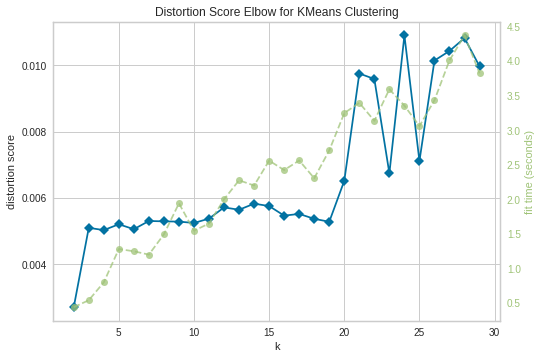

In [21]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

features = ['longitude', 'latitude']
x = df.loc[:, features].values

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 30))

visualizer.fit(x)        # Fit the data to the visualizer
visualizer.poof()        # Draw/show/poof the data

In [22]:
# cluster the locations

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=12, n_jobs=-1)
train['cluster'] = kmeans.fit_predict(train[['longitude', 'latitude']])
test['cluster'] = kmeans.predict(test[['longitude', 'latitude']])
px.scatter(train, x='longitude', y='latitude', color='cluster')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [23]:
def engineer_features(df):
    clusters = pd.get_dummies(df['cluster'], prefix='cluster')
    for col in clusters:
        df[col] = clusters[col]
#   interest level      
    interest_level = pd.get_dummies(df['interest_level'], prefix='interest_level')
    for col in interest_level:
        df[col] = interest_level[col]
        
    df['description'] = df['description'].str.strip().fillna('')
    df['has_description'] = df['description'] != ''
#   description length
    df['description_length'] = df['description'].str.len()

#   perk_count
    perk_cols = ['elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
                 'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
                 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
                 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
                 'swimming_pool', 'new_construction', 'exclusive', 'terrace', 
                 'loft', 'garden_patio', 'common_outdoor_space', 
                 'wheelchair_access']
    df['perk_count'] = df[perk_cols].sum(axis=1)

#   are cats or dogs allowed?
    df['cats_or_dogs'] = (df['cats_allowed']==1) | (df['dogs_allowed']==1)

#   are cats and dogs allowed?
    df['cats_and_dogs'] = (df['cats_allowed']==1) & (df['dogs_allowed']==1)

#   total number of rooms
    df['rooms'] = df['bedrooms'] + df['bathrooms']

#   ratio of baths to beds
    df['ratio_baths_beds'] =  df['bathrooms'] / df['bedrooms']
    
    return df

    
train = engineer_features(train)
test = engineer_features(test)
train.shape, test.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

((31844, 57), (16973, 57))

In [25]:
# mean baseline 

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_train = train['price']
y_test = test['price']
y_pred_train = [y_train.mean()] * len(y_train)
y_pred_test  = [y_train.mean()] * len(y_test)

print('Mean Baseline:')
print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('Test Root Mean Square Error:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Train Mean Absolute Error:', mean_absolute_error(y_train, y_pred_train))
print('Test Mean Absolute Error:', mean_absolute_error(y_test, y_pred_test))
print('Train R^2 Score:', r2_score(y_train, y_pred_train))
print('Test R^2 Score:', r2_score(y_test, y_pred_test))

Mean Baseline:
Train Root Mean Squared Error: 1762.1090255404863
Test Root Mean Square Error: 1762.9952880399528
Train Mean Absolute Error: 1201.8811133682555
Test Mean Absolute Error: 1197.7088871089013
Train R^2 Score: 0.0
Test R^2 Score: -4.218690517676649e-05


In [0]:
# fit a linear regression model

from sklearn.linear_model import LinearRegression

def lr(train, test, features, target):
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print(f'Linear Regression with {len(features)} features')
    print('Intercept', model.intercept_)
    coefficients = pd.Series(model.coef_, features)
    print(coefficients.to_string())
    
    print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print('Test Root Mean Square Error:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print('Train Mean Absolute Error:', mean_absolute_error(y_train, y_pred_train))
    print('Test Mean Absolute Error:', mean_absolute_error(y_test, y_pred_test))
    print('Train R^2 Score:', r2_score(y_train, y_pred_train))
    print('Test R^2 Score:', r2_score(y_test, y_pred_test))

In [46]:
target = 'price'
features = ['bedrooms', 'bathrooms', 'latitude', 'perk_count', 'loft',
            'high_speed_internet', 'doorman', 'description_length',
            'cluster_0', 'cluster_1', 'cluster_2', 'cluster_4', 
            'cluster_5', 'cluster_6', 'cluster_7', 'cluster_11', 
            'interest_level_high', 'interest_level_medium', 'interest_level_low']
lr(train, test, features, target)

Linear Regression with 19 features
Intercept 8609.06832550356
bedrooms                  504.020149
bathrooms                1869.031679
latitude                 -237.521560
perk_count                 42.738683
loft                     -224.557007
high_speed_internet      -321.972485
doorman                   396.142485
description_length          0.134471
cluster_0                 775.831788
cluster_1                 858.213968
cluster_2                 -14.813919
cluster_4                 707.376868
cluster_5                1438.588405
cluster_6                 108.154553
cluster_7                 991.885507
cluster_11                838.526025
interest_level_high      -329.774776
interest_level_medium    -104.249189
interest_level_low        434.023965
Train Root Mean Squared Error: 1088.274073893441
Test Root Mean Square Error: 1083.8200419377608
Train Mean Absolute Error: 711.6234004859239
Test Mean Absolute Error: 728.1048114634675
Train R^2 Score: 0.6185733665528607
Test R^2 Scor